# Compute STF source parameter statistics

We dump the datasheet of the estimated source parameters.

2024.11.28 Kurama Okubo


In [33]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle
import copy

import seaborn as sns 
from scipy.interpolate import LSQUnivariateSpline
from scipy import integrate
from scipy.interpolate import CubicSpline

import h5py # store the STF in hdf5
from scipy.optimize import minimize

from STFfit_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [34]:
dataoutdir = "../data/05_STFstats"
if not os.path.exists(dataoutdir):
    os.makedirs(dataoutdir)

In [35]:
figdir = "../figure/05_STFstats/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Read the STF

In [36]:
gougepatch_id = "G3" # to set output filename
denoise_method = "detrend"
k_waterlevel = 0.3
Qinv_quart = 50

fo = h5py.File(f"../data/03_computePdisp/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r+')


In [37]:
# selected AE sensors for patch G3
AEsensor_list = ["OL23", "OL07", "OL08", "OL22"] # update: we use 4 close sensors "OL24"] 

In [38]:
tvec = np.array(fo[f"param/tvec_upsampled_margintrimmed"])

pwin_pre = fo[f"param"].attrs["pwin_pre"]
dt_upsampled = fo[f"param"].attrs["dt_upsampled"]
pwin_pre = fo[f"param"].attrs["pwin_pre"]
pwin_len = fo[f"param"].attrs["pwin_len"] 
k_waterlevel = fo[f"param"].attrs["k_waterlevel"] 


In [39]:
fo[f"param"].attrs.keys()

<KeysViewHDF5 ['NFFT', 'denoise_method', 'dt_upsampled', 'k_waterlevel', 'polyfit_Rcontinu_buffer', 'polyfit_smooth_lowpass_freqmax', 'polyfit_winlens', 'polyords', 'pwin_len', 'pwin_pre', 'trim_margin']>

In [40]:
datacases = list(fo.keys())
datacases.remove("param")
# datacases

# Compute the datasheets

We read the best-fit source parameters and store them to the pandas dataframe to dump for the master datasheet csv.

We prepare the datasheets as follows:

1. Source parameters of each sensor and gouge event
2. Mean values of the source parameters 

## 1. Source parameters of each sensor and event

In [41]:
expr_id = 87

error_thresh = 0.06 #0.05 #0.05
SNR_thresh = 4.5 #3.0 # P peak / STD of noise

Qinv_quart = 50

stf_type = "cosine"

### 1. With Q deconv

In [42]:
columns = ["index", "expr_id", "datacase", "gougeevent_id", "AEsensor", "Qinv_quart", "M0", "Tw", "Tshift", "stf_type", "peakSTFamp", "fitting_flag", "RMSE", "error_fraction", "error_thresh", "SNR_sensor", "SNR_thresh", "validflag", ] 
df_sourceparam = pd.DataFrame(columns = columns)
df_sourceparam

for datacase in datacases:
    for stnm in AEsensor_list:
        gougeevent_id = int(datacase.split("__")[1])

        fitting_flag = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["fitting_flag"],
        error_fraction = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["error_fraction"]
        SNR_sensor = fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["SNR_sensor"]

        if fitting_flag & (error_fraction < error_thresh) & (SNR_sensor>SNR_thresh):
            validflag = 1
        else:
            validflag = 0

        datadict = {
        "index": [f"fb03-{expr_id:03d}__OL{int(stnm[2:]):02d}"],
        "expr_id": f"fb03-{expr_id:03d}",
        "datacase": datacase,
        "gougeevent_id": gougeevent_id,
        "AEsensor": int(stnm[2:]),      
        "Qinv_quart": Qinv_quart,
        "M0": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["M0_best"],
        "Tw": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["TR_best"],
        "Tshift": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["tshift_best"],
        "stf_type": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["stf_type"],
        "peakSTFamp": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["max_STF_bestfit"],
        "fitting_flag": fitting_flag,
        "error_fraction": error_fraction,
        "error_thresh": error_thresh,
        "RMSE": fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["RMSE"],
        "SNR_sensor": SNR_sensor,
        "SNR_thresh": SNR_thresh,
        "validflag": validflag,
        }

        if not df_sourceparam.empty:
            df_sourceparam = pd.concat([df_sourceparam, pd.DataFrame.from_dict(datadict)])
        else:
            df_sourceparam = pd.DataFrame.from_dict(datadict)

# df_sourceparam = df_sourceparam.set_index("index");

In [43]:
df_sourceparam.head()

,index,expr_id,datacase,gougeevent_id,AEsensor,Qinv_quart,M0,Tw,Tshift,stf_type,peakSTFamp,fitting_flag,error_fraction,error_thresh,RMSE,SNR_sensor,SNR_thresh,validflag
0,fb03-087__OL23,fb03-087,fb03-087__0004,4,23,50,0.359696,0.000003,2.670093e-08,cosine,284758.896542,True,0.005793,0.06,1649.667086,15.188115,4.5,1
0,fb03-087__OL07,fb03-087,fb03-087__0004,4,7,50,0.664096,0.000003,-1.680312e-08,cosine,481268.786140,True,0.008789,0.06,4230.094707,23.997937,4.5,1
0,fb03-087__OL08,fb03-087,fb03-087__0004,4,8,50,0.565188,0.000002,3.452641e-08,cosine,473145.066183,True,0.003973,0.06,1879.577637,27.235554,4.5,1
0,fb03-087__OL22,fb03-087,fb03-087__0004,4,22,50,0.781447,0.000003,-2.860772e-08,cosine,610433.242765,True,0.010949,0.06,6683.936242,29.751407,4.5,1
0,fb03-087__OL23,fb03-087,fb03-087__0009,9,23,50,0.037183,0.000003,-1.917913e-07,cosine,27391.874270,True,0.059322,0.06,1624.947861,8.756880,4.5,1


### 2. Without Q deconv

In [44]:
error_thresh_noQcorr = 0.06 #0.05 #0.05
SNR_thresh_noQcorr = 4.5 #3.0 # P peak / STD of noise

for datacase in datacases:
    for stnm in AEsensor_list:
        gougeevent_id = int(datacase.split("__")[1])

        fitting_flag = fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["fitting_flag"],
        error_fraction = fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["error_fraction"]
        SNR_sensor = fo[f"{datacase}/{stnm}/noQcorr"].attrs["SNR_sensor"]

        if fitting_flag & (error_fraction < error_thresh_noQcorr) & (SNR_sensor>SNR_thresh_noQcorr):
            validflag = 1
        else:
            validflag = 0

        datadict = {
        "index": [f"fb03-{expr_id:03d}__OL{int(stnm[2:]):02d}"],
        "expr_id": f"fb03-{expr_id:03d}",
        "datacase": datacase,
        "gougeevent_id": gougeevent_id,
        "AEsensor": int(stnm[2:]),      
        "Qinv_quart": "noQcorr",
        "M0": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["M0_best"],
        "Tw": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["TR_best"],
        "Tshift": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["tshift_best"],
        "stf_type": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["stf_type"],
        "peakSTFamp": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["max_STF_bestfit"],
        "fitting_flag": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["fitting_flag"],
        "error_fraction": error_fraction,
        "error_thresh": error_thresh_noQcorr,
        "RMSE": fo[f"{datacase}/{stnm}/noQcorr/{stf_type}"].attrs["RMSE"],
        "SNR_sensor": SNR_sensor,
        "SNR_thresh": SNR_thresh_noQcorr,
        "validflag": validflag,
        }

        df_sourceparam = pd.concat([df_sourceparam, pd.DataFrame.from_dict(datadict)])

df_sourceparam = df_sourceparam.set_index("index");

In [45]:
df_sourceparam.head()

,expr_id,datacase,gougeevent_id,AEsensor,Qinv_quart,M0,Tw,Tshift,stf_type,peakSTFamp,fitting_flag,error_fraction,error_thresh,RMSE,SNR_sensor,SNR_thresh,validflag
index,,,,,,,,,,,,,,,,,
fb03-087__OL23,fb03-087,fb03-087__0004,4,23,50,0.359696,0.000003,2.670093e-08,cosine,284758.896542,True,0.005793,0.06,1649.667086,15.188115,4.5,1
fb03-087__OL07,fb03-087,fb03-087__0004,4,7,50,0.664096,0.000003,-1.680312e-08,cosine,481268.786140,True,0.008789,0.06,4230.094707,23.997937,4.5,1
fb03-087__OL08,fb03-087,fb03-087__0004,4,8,50,0.565188,0.000002,3.452641e-08,cosine,473145.066183,True,0.003973,0.06,1879.577637,27.235554,4.5,1
fb03-087__OL22,fb03-087,fb03-087__0004,4,22,50,0.781447,0.000003,-2.860772e-08,cosine,610433.242765,True,0.010949,0.06,6683.936242,29.751407,4.5,1
fb03-087__OL23,fb03-087,fb03-087__0009,9,23,50,0.037183,0.000003,-1.917913e-07,cosine,27391.874270,True,0.059322,0.06,1624.947861,8.756880,4.5,1


In [46]:
fo.close()

In [47]:
foname_all = dataoutdir+f"/SourceParam_allsensors_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_sourceparam.to_csv(foname_all, float_format='%12.8e')

In [48]:
dataoutdir

'../data/05_STFstats'

## 2. Mean values of the source parameters

### 1. With Q deconv

In [49]:
df_sourceparam["Qinv_quart"]==Qinv_quart

index
fb03-087__OL23     True
fb03-087__OL07     True
fb03-087__OL08     True
fb03-087__OL22     True
fb03-087__OL23     True
                  ...  
fb03-087__OL22    False
fb03-087__OL23    False
fb03-087__OL07    False
fb03-087__OL08    False
fb03-087__OL22    False
Name: Qinv_quart, Length: 352, dtype: bool

In [50]:
columns = ["index", "datacase", "gougeevent_id", "Qinv_quart", "Nvalidsensors", "M0_mean", "Tw_mean", "M0_std", "Tw_std"] 
df_stats = pd.DataFrame(columns = columns)

for datacase in datacases:    
    gougeevent_id = int(datacase.split("__")[1])
    
    # select the  valid sensors
    df_event = df_sourceparam[(df_sourceparam["Qinv_quart"]==Qinv_quart) & (df_sourceparam["datacase"] == datacase) & (df_sourceparam["validflag"] == True)]
    Nvalidsensors = len(df_event)

    if Nvalidsensors < 1:
        M0_mean = np.nan
        Tw_mean = np.nan
    else:       
        M0_mean = np.mean(df_event["M0"].values)
        Tw_mean = np.mean(df_event["Tw"].values)
   
    if Nvalidsensors < 2:
        M0_std = np.nan
        Tw_std = np.nan
    else:       
        M0_std = np.std(df_event["M0"].values, ddof=1)
        Tw_std = np.std(df_event["Tw"].values, ddof=1)

    datadict = {
        "index": [f"fb03-{expr_id:03d}"],
        "datacase": datacase,
        "gougeevent_id": gougeevent_id,
        "Qinv_quart": Qinv_quart,
        "Nvalidsensors": Nvalidsensors,
        "M0_mean": M0_mean,
        "M0_std": M0_std,
        "Tw_mean": Tw_mean,
        "Tw_std": Tw_std,
        }

    if not df_stats.empty:
        df_stats = pd.concat([df_stats, pd.DataFrame.from_dict(datadict)])
    else:
        df_stats = pd.DataFrame.from_dict(datadict)


In [51]:
df_stats.head()

,index,datacase,gougeevent_id,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std
0,fb03-087,fb03-087__0004,4,50,4,0.592607,0.178671,0.000003,1.530315e-07
0,fb03-087,fb03-087__0009,9,50,4,0.046991,0.007419,0.000002,3.643121e-07
0,fb03-087,fb03-087__0018,18,50,4,0.755830,0.192507,0.000003,3.100882e-07
0,fb03-087,fb03-087__0019,19,50,4,0.055755,0.016951,0.000002,2.699155e-07
0,fb03-087,fb03-087__0020,20,50,4,0.865466,0.210250,0.000003,1.352659e-07


### 2. Without Q deconv

In [52]:
for datacase in datacases:    
    gougeevent_id = int(datacase.split("__")[1])
    
    # select the  valid sensors
    df_event = df_sourceparam[(df_sourceparam["Qinv_quart"]=="noQcorr") & (df_sourceparam["datacase"] == datacase) & (df_sourceparam["validflag"] == True)]
    Nvalidsensors = len(df_event)

    if Nvalidsensors < 1:
        M0_mean = np.nan
        Tw_mean = np.nan
    else:       
        M0_mean = np.mean(df_event["M0"].values)
        Tw_mean = np.mean(df_event["Tw"].values)
   
    if Nvalidsensors < 2:
        M0_std = np.nan
        Tw_std = np.nan
    else:       
        M0_std = np.std(df_event["M0"].values, ddof=1)
        Tw_std = np.std(df_event["Tw"].values, ddof=1)

    datadict = {
        "index": [f"fb03-{expr_id:03d}"],
        "datacase": datacase,
        "gougeevent_id": gougeevent_id,
        "Qinv_quart": "noQcorr",
        "Nvalidsensors": Nvalidsensors,
        "M0_mean": M0_mean,
        "M0_std": M0_std,
        "Tw_mean": Tw_mean,
        "Tw_std": Tw_std,
        }
        
    df_stats = pd.concat([df_stats, pd.DataFrame.from_dict(datadict)])

df_stats = df_stats.set_index("index");

In [53]:
foname_mean = dataoutdir+f"/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"
df_stats.to_csv(foname_mean, float_format='%12.8e')


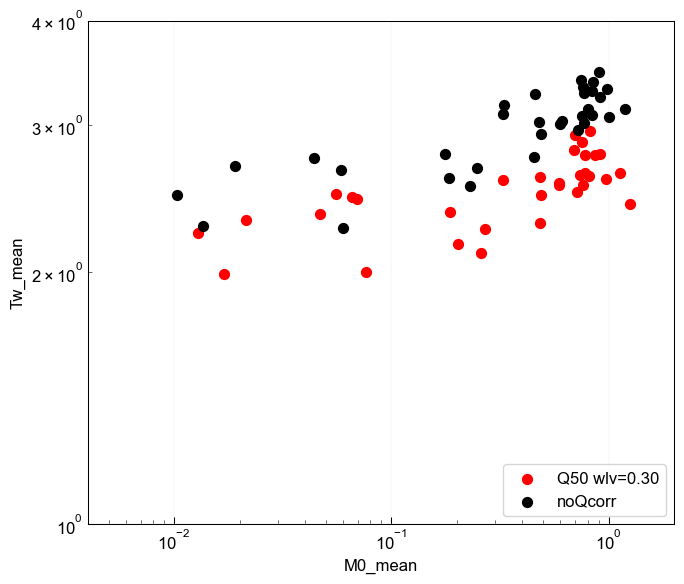

In [54]:
Nvalidsensors_thresh = 4

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
df_stats_filt = df_stats[(df_stats["Nvalidsensors"]==Nvalidsensors_thresh) & (df_stats["Qinv_quart"]==Qinv_quart)].copy()
df_stats_filt["Tw_mean"] *= 1e6
df_stats_filt["Tw_std"] *= 1e6
df_stats_filt.plot(x="M0_mean", y="Tw_mean", kind="scatter", ax=ax, xlim=(0.004, 2), ylim=(1, 4),
                   loglog=True, s=50, c="r", marker="o", label=f"Q{Qinv_quart} wlv={k_waterlevel:.2f}")

df_stats_filt = df_stats[(df_stats["Nvalidsensors"]==Nvalidsensors_thresh) & (df_stats["Qinv_quart"]=="noQcorr")].copy()
df_stats_filt["Tw_mean"] *= 1e6
df_stats_filt["Tw_std"] *= 1e6
df_stats_filt.plot(x="M0_mean", y="Tw_mean", kind="scatter", ax=ax, xlim=(0.004, 2), ylim=(1, 4),
                   loglog=True, s=50, c="k", marker="o", label="noQcorr")

ax.legend(loc=4)

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()


In [55]:
len(df_stats_filt)

33

# Plot moment-duration scaling for each sensor

In [56]:
fo = h5py.File(f"../data/03_computePdisp/STF_all_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.hdf5", 'r')


In [57]:
def get_selfsim_scaling(k, beta, delsig, M0):
    return (1/(k*beta)) * (7/(16*delsig))**(1/3) * M0**(1/3)


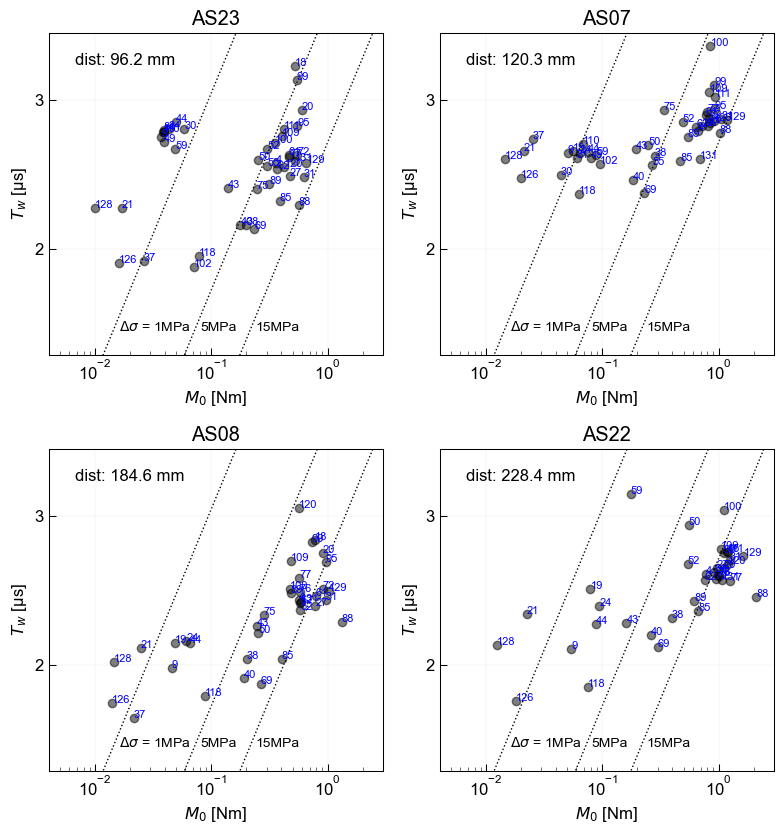

In [58]:
expr_id = 87

error_thresh = 0.06 #0.05 #0.05
SNR_thresh = 4.5 #8.0 # P peak / STD of noise

Qinv_quart = 50

stf_type = "cosine"

M0_all = []
TR_all = []

fig, axs = plt.subplots(2, 2, figsize=(8, 8.5))

vs = 3600 #[m/s]

ifPlotSelfSimLines = True

for i, ax in enumerate(axs.flatten()):
    
    stnm = AEsensor_list[i]
    tx = []
    
    for datacase in datacases:

        gougeevent_id = int(datacase.split("__")[1])
      
        M0_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["M0_best"]
        TR_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["TR_best"]
        stf_type_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["stf_type"]
        fitting_flag = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["fitting_flag"]
        error_fraction = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["error_fraction"]
        SNR_sensor = fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["SNR_sensor"]

        if fitting_flag & (error_fraction < error_thresh) & (SNR_sensor>SNR_thresh):
            valid = 1
            mt = "o"
        else:
            valid = 0
            mt = "x"
    
        if valid:
            ax.plot(M0_best, TR_best*1e6, marker=mt, c="0", alpha=0.5)
            tx_ev = ax.text(M0_best, TR_best*1e6, f"{gougeevent_id}", clip_on = True, fontsize=8, c="b", zorder=10)
            tx.append(tx_ev)


    # # M0_selfsim = np.linspace(0, 2, 101)
    # M0_selfsim = np.logspace(-3, 1.2, 101)
    
    # delsig_list = [5e6, 15e6] #[5e6, 10e6, 20e6]
    # delsig_annot_y = [1.2, 1., .8]

    # # k_rup = 0.32 # P wave for vr = 0.9cs
    # delsig_ls = [":", "--"]

    if ifPlotSelfSimLines:
        M0_selfsim = np.logspace(-3, 1.2, 101)
        
        delsig_list = [1e6, 5e6, 15e6] #[5e6, 10e6, 20e6]
        # delsig_annot_x = [1.35e-2, 2.5e-2, 7.5e-2]
        # delsig_annot_y = [1.55, 1.35, 1.25]
        
        # delsig_annot_x = np.array([1.12e-2, 5.7e-2, 1.7e-1]) # update 2025/1/23
        delsig_annot_x = np.array([1.6e-2, 8.1e-2, 2.4e-1]) # update 2025/1/23
        delsig_annot_y = [1.6, 1.6, 1.6] #[1.16, 1.16, 1.16]
        
        # k_rup = 0.32 # P wave for vr = 0.9cs
        delsig_ls = [":", "--"]
        
        # C_k = [0.15, 0.32]
        C_k = [0.32]
        for k, k_rup in enumerate(C_k): # for 0.6vs and 0.9vs
        
            for j, delsig in enumerate(delsig_list):
                TR_selfsim = get_selfsim_scaling(k_rup, vs, delsig, M0_selfsim)
                ax.plot(M0_selfsim, TR_selfsim*1e6, "k", ls=delsig_ls[k], lw=1, zorder=-1, label=None)
                
                if j == 0:
                    delsigstr = r'$\Delta \sigma$ = {:.0f}MPa'.format(delsig/1e6)
                else:
                    delsigstr = '{:.0f}MPa'.format(delsig/1e6)
                    
                ax.text(delsig_annot_x[j], delsig_annot_y[j], delsigstr, fontsize=10)


    # compute source dist
    
    df_event = pd.read_csv(f"../data/02_trim_Pwave/trimP_coefficients_G3_{stnm}.csv")
    dist = df_event.rdist.mean()
    ax.text(0.08, 0.9, f"dist: {dist*1e3:.1f} mm", transform=ax.transAxes)
    
    ax.set_title(f"AS{stnm[2:]}")
    ax.set_xlabel("$M_0$ [Nm]")
    ax.set_ylabel("$T_w$ [μs]")
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim([0.006, 2])
    # ax.set_xlim([0.03, 2])
    # ax.set_ylim([0.0, 4])

    xlimit_scaling = [0.004, 3] #10] # check 1/3
    ax.set_xlim(xlimit_scaling)
    # ax.set_ylim([1.0, 4])
    ax.set_ylim([1.5, 3.6]) #10]) # update 2025/1/23 # check 1/3

    ax.set_yticks([2, 3, ]) # update 2025/1/23
    ax.set_yticklabels([2, 3, ]) # update 2025/1/23

    # ax.set_xlim([0.03, 2])

    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
    ax.set_axisbelow('True')


# plt.suptitle(f'Q{Qinv_quart} water-level={k_waterlevel:.2f}', y=0.98)

plt.tight_layout()

plt.savefig(figdir+f"/STF_M0TRscaling_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_eachsensor.png", format="png", dpi=70)
plt.savefig(figdir+f"/STF_M0TRscaling_fb03-{expr_id:03d}_{gougepatch_id}_Q{Qinv_quart}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}_eachsensor.eps", format="png")

# plt.clf()
# plt.close()



# Plot panels of source parameter estimates

In [59]:
thresh_Nsensor = 4 #3 #2

datacases_thresh_Nsensor = []
mean_M0 = []
mean_TR = []
std_M0 = []
std_TR = []
mean_datacase = []
# evaluate the number of valid sensor
for datacase in datacases:

    valid_Nsensor = 0
    M0sum = []
    TRsum = []
    for i, stnm in enumerate(AEsensor_list):
        fitting_flag = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["fitting_flag"]
        error_fraction = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["error_fraction"]
        SNR_sensor = fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["SNR_sensor"]
    
        if fitting_flag & (error_fraction < error_thresh) & (SNR_sensor>SNR_thresh):
            M0_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["M0_best"]
            TR_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["TR_best"]
            valid_Nsensor += 1
            M0sum.append(M0_best)
            TRsum.append(TR_best)
    
    if valid_Nsensor>=thresh_Nsensor:
        datacases_thresh_Nsensor.append(datacase)
        mean_M0.append(np.mean(M0sum))
        mean_TR.append(np.mean(TRsum))
        std_M0.append(np.std(M0sum, ddof=1))
        std_TR.append(np.std(TRsum, ddof=1))
        mean_datacase.append(datacase)

datacases_thresh_Nsensor = np.array(datacases_thresh_Nsensor)

In [60]:
sorted_inds = np.argsort(mean_M0)

In [61]:
datacases_thresh_Nsensor, len(datacases_thresh_Nsensor)

(array(['fb03-087__0004', 'fb03-087__0009', 'fb03-087__0018',
        'fb03-087__0019', 'fb03-087__0020', 'fb03-087__0021',
        'fb03-087__0024', 'fb03-087__0027', 'fb03-087__0031',
        'fb03-087__0038', 'fb03-087__0040', 'fb03-087__0043',
        'fb03-087__0044', 'fb03-087__0050', 'fb03-087__0052',
        'fb03-087__0061', 'fb03-087__0062', 'fb03-087__0069',
        'fb03-087__0072', 'fb03-087__0077', 'fb03-087__0085',
        'fb03-087__0088', 'fb03-087__0089', 'fb03-087__0095',
        'fb03-087__0099', 'fb03-087__0100', 'fb03-087__0109',
        'fb03-087__0118', 'fb03-087__0120', 'fb03-087__0126',
        'fb03-087__0128', 'fb03-087__0129', 'fb03-087__0131'], dtype='<U14'),
 33)

In [62]:
skipcolor = 2
lc_selected = dict()
c_norm = mpl.colors.Normalize(vmin=0, vmax=len(datacases_thresh_Nsensor)+skipcolor)
cmap = sns.color_palette("tab20", as_cmap=True) # for tab 20 not ordering to distribute the color
for i, datacase in enumerate(datacases_thresh_Nsensor):
    lc_selected[datacase] = cmap(c_norm(i+skipcolor))


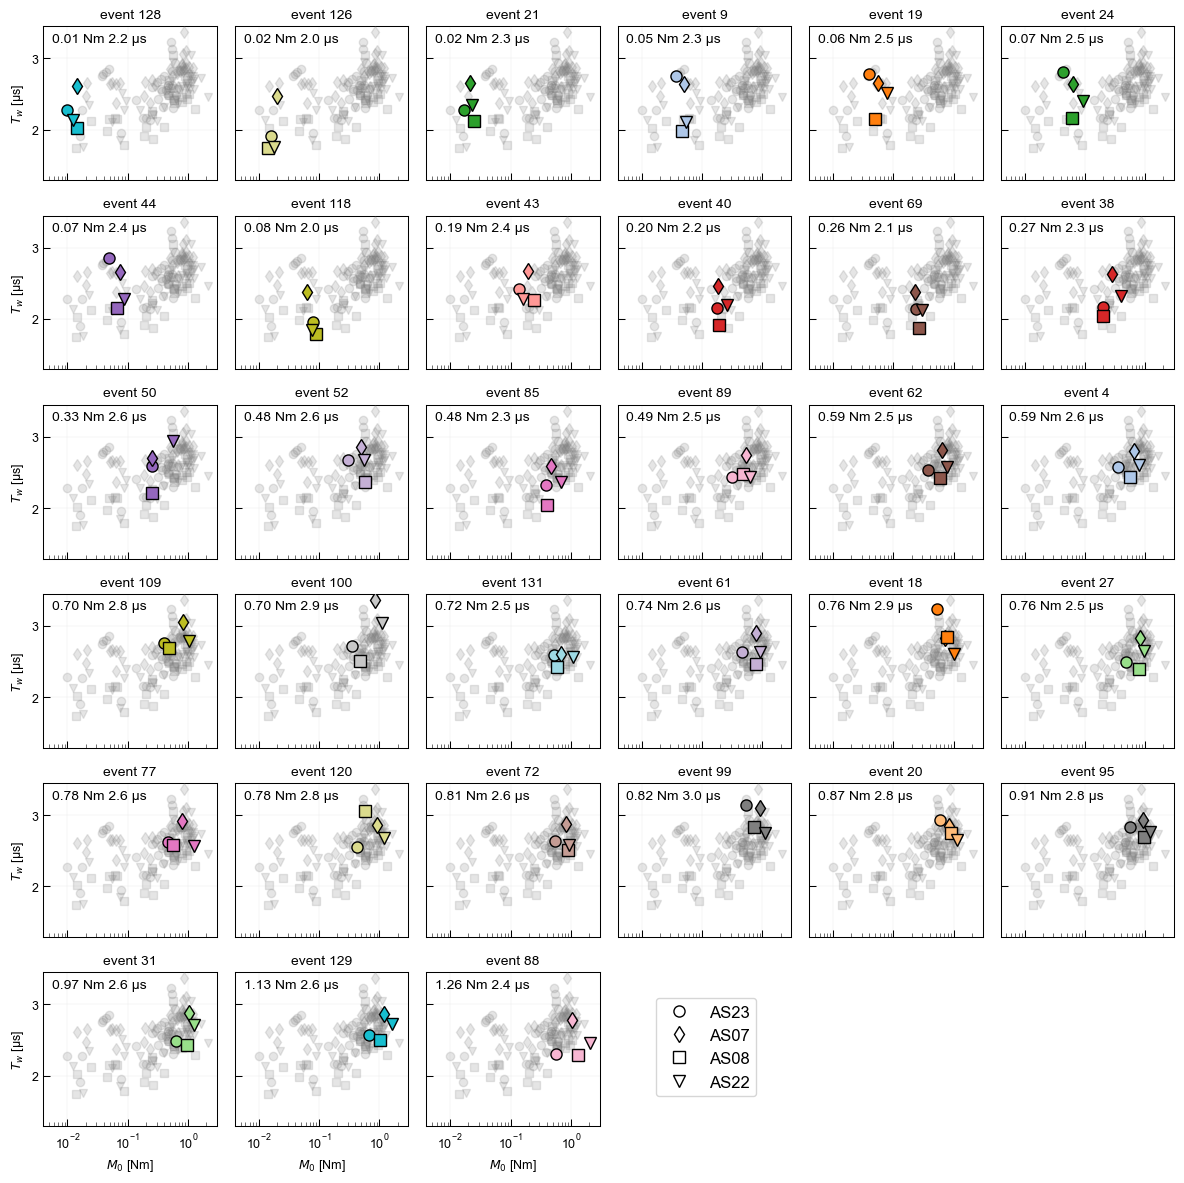

In [63]:
left=0.1
right=0.9
bottom=0.1
top=0.9
wspace=0.15
hspace=0.1

Ndim_x = 6
Ndim_y = 6

fig, axs = plt.subplots(Ndim_y, Ndim_x, figsize=(12,12))

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

# xlimit = [0.004, 3]
# ylimit = [1, 5]
ylimit = [1.5, 3.6]

labelfontsize = 9
tickfontsize = 9

ylabelstr = "$M_0$ [Nm]"

Qindex = "Q50" 

mctype = ["o", "d", "s", "v"]

for ii in range(Ndim_y):
    for jj in range(Ndim_x):
        
        i_datacase = ii*Ndim_x + jj
        if i_datacase >= len(datacases_thresh_Nsensor):
            axs[ii, jj].set_axis_off()
            continue
        
        # datacase_master = datacases_thresh_Nsensor[i_datacase]
        datacase_master = datacases_thresh_Nsensor[sorted_inds[i_datacase]]
        gougeevent_id_master = int(datacase_master.split("__")[1])
        
        ax = axs[ii, jj]
        
        # 1. Plot all 
        M0_all = []
        TR_all = []
        labelflag = 0

        for k, datacase in enumerate(datacases_thresh_Nsensor):
            for i, stnm in enumerate(AEsensor_list):
                gougeevent_id = int(datacase.split("__")[1])
              
                M0_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["M0_best"]
                TR_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["TR_best"]
                stf_type_best = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["stf_type"]
                fitting_flag = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["fitting_flag"]
                error_fraction = fo[f"{datacase}/{stnm}/Q{Qinv_quart}/{stf_type}"].attrs["error_fraction"]
                SNR_sensor = fo[f"{datacase}/{stnm}/Q{Qinv_quart}"].attrs["SNR_sensor"]
            
                if fitting_flag & (error_fraction < error_thresh) & (SNR_sensor>SNR_thresh):
                    valid = 1
                    mt = "o"
                else:
                    valid = 0
                    mt = "x"
        
                if datacase == datacase_master:
                    malpha=1.0
                    cc = lc_selected[datacase_master]
                    zorder = 4
                    ms=8
                    mec="k"
                    M0_all.append(M0_best)
                    TR_all.append(TR_best)
                else:
                    malpha=0.2
                    cc = "gray"
                    zorder = 3
                    ms=6
                    mec=None
                    
                if valid:
                    if labelflag < 4:
                        label = stnm
                        labelflag += 1
                    else:
                        label = ""

                ax.plot(M0_best, TR_best*1e6, marker=mctype[i], c=cc, mec=mec, markersize=ms, label=label, alpha=malpha, zorder=zorder)

                
        # annotate average source parameter
        tx_ev = ax.text(0.05, 0.9, f"{np.mean(M0_all):.2f} Nm {np.mean(TR_all)*1e6:.1f} μs",  fontsize=10, c="k", zorder=10, transform=ax.transAxes)
        # tx.append(tx_ev)

        # set the axis format
        ax.set_xlim(xlimit_scaling)
        ax.set_ylim(ylimit)
        ax.set_title(f"event {gougeevent_id_master}", fontsize=10)

        # ax.set_xlabel("M0 [Nm]")
        # ax.set_ylabel("Tw [μs]")
        ax.set_xscale('log')
        ax.set_yscale('log')

        # ax.set_yticks([1, 2, 3, 4])
        # ax.set_yticklabels([1, 2, 3, 4])
        ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
        ax.set_axisbelow('True')
        # ax.legend(loc=0, handlelength=0)
    
        if jj==0:
            ax.set_ylabel(r"$T_w$ [μs]", fontsize=labelfontsize)
            ax.set_yticks([ 2, 3, ])
            ax.set_yticklabels([ 2, 3, ])
        else:
            ax.set_yticks([2, 3, ])
            ax.set_yticklabels([])

        if ii==Ndim_y-1:
            ax.set_xlabel("$M_0$ [Nm]", fontsize=labelfontsize)
    #       plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
        else:
            ax.set(xticklabels=[])
    
        plt.setp(ax.get_xticklabels(), fontsize=tickfontsize)
        plt.setp(ax.get_yticklabels(), fontsize=tickfontsize)

plt.tight_layout()

# plot legend
legend_ax = fig.add_axes([0.52, 0.02, 0.15, 0.2])  # [left, bottom, width, height]
# make dummy markers
for i, stnm in enumerate(AEsensor_list):
    line1, = legend_ax.plot(0, 0, ls="", marker=mctype[i], mec="k", mfc="w", ms=8, label=f"AS{stnm[2:]}") 

legend = legend_ax.legend(loc="center") 
# Remove all lines from the plot
legend_ax.clear()
# Re-add the legend to the cleared plot
legend_ax.add_artist(legend)
legend_ax.axis("off")  # Hide the axis


plt.savefig(figdir + f"/ScalingPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.png", dpi=70, bbox_inches="tight")
plt.savefig(figdir + f"/ScalingPanel_{gougepatch_id}_{Qindex}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.pdf", bbox_inches="tight")


In [64]:
fo.close()